# Ray et al 2013 Exploratory Data Analysis
**Authorship:**
Adam Klie, *08/27/2022*
***
**Description:**
Notebook to perform a breif EDA on the Ray et al (2013) dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import eugene as eu
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

Global seed set to 13
/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


# Download and load in the dataset to a raw `SeqData` object

In [2]:
sdata = eu.datasets.ray13()

Dataset ray13 norm_data.txt.gz has already been dowloaded.


In [3]:
np.all(sdata.names == sdata.seqs_annot.index)

True

In [4]:
target_mask = sdata.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata.seqs_annot.columns[target_mask]
len(target_cols)

244

In [5]:
sdata["seq_len"] = [len(seq) for seq in sdata.seqs]

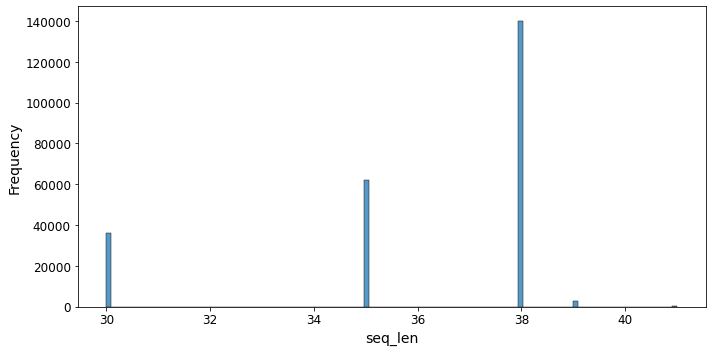

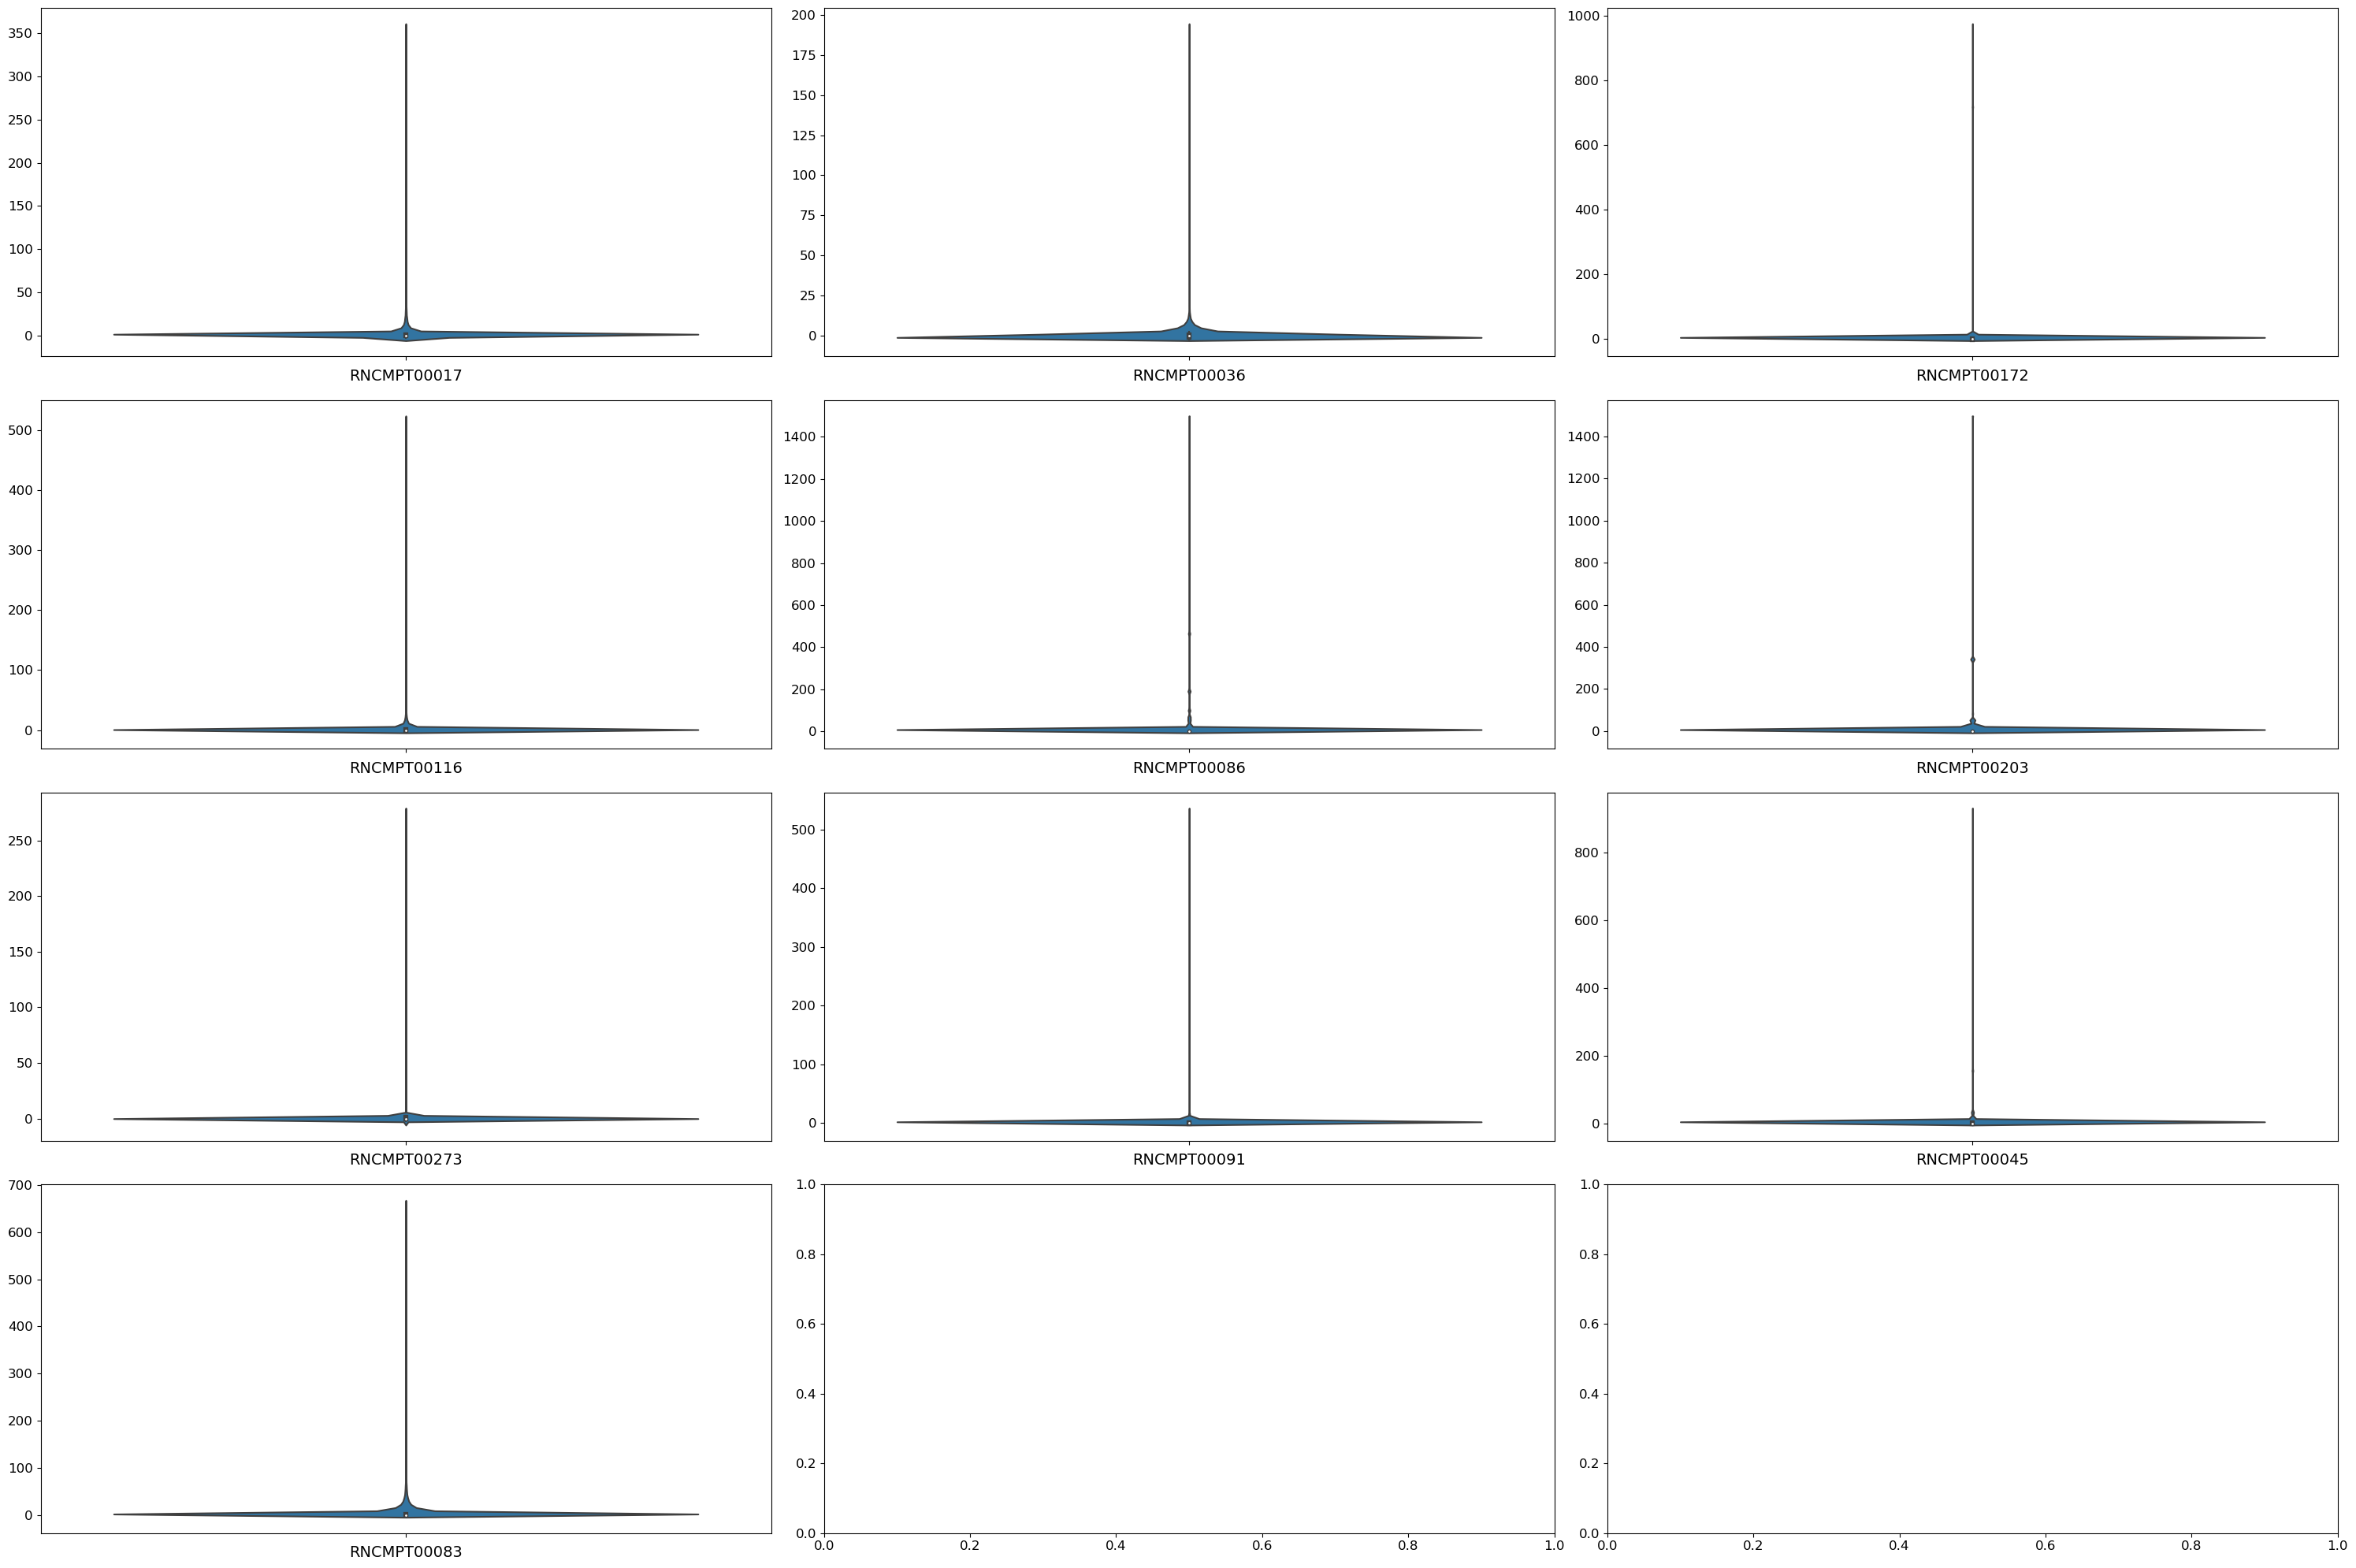

In [6]:
eu.pl.histplot(
    sdata, 
    keys="seq_len", 
    orient="h"
)
eu.pl.violinplot(
    sdata, 
    keys=np.random.choice(target_cols, 10)
)

<AxesSubplot:ylabel='Frequency'>

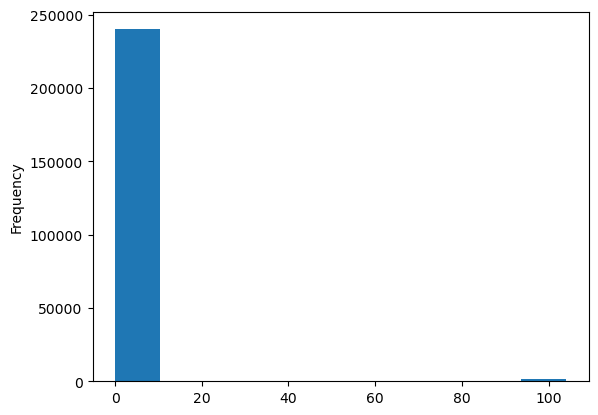

In [7]:
sdata.seqs_annot.isna().sum(axis=1).plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

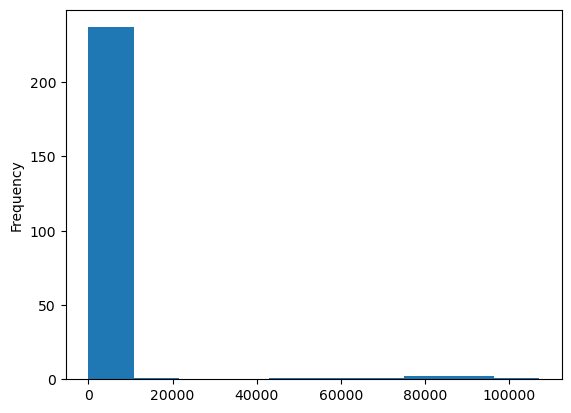

In [8]:
sdata.seqs_annot.isna().sum(axis=0).plot(kind="hist")

In [9]:
nan_percents = sdata.seqs_annot[target_cols].isna().sum(axis=0).sort_values(ascending=False)/sdata.seqs_annot.shape[0]

In [16]:
cleaned_annot = sdata.seqs_annot.drop(nan_percents[nan_percents > 0.01].index, axis=1)

In [28]:
cleaned_cols = target_cols.drop(nan_percents[nan_percents > 0.01].index)

In [29]:
len(cleaned_cols)

233

In [30]:
len(np.where(cleaned_annot[cleaned_cols].isna().sum(axis=1) == 0)[0])

221796

In [20]:
221796/sdata.n_obs

0.9189540804700091

In [32]:
sdata.seqs_annot.isna().sum(axis=1).sort_values(ascending=False)[:20]

seq133747    104
seq117002    103
seq092826    102
seq124203    102
seq061395    102
seq195223    102
seq113624    102
seq146323    101
seq093392    101
seq044638    100
seq088282    100
seq036382    100
seq083383    100
seq010609    100
seq005807    100
seq198815     99
seq171734     99
seq000748     99
seq233144     99
seq162007     99
dtype: int64

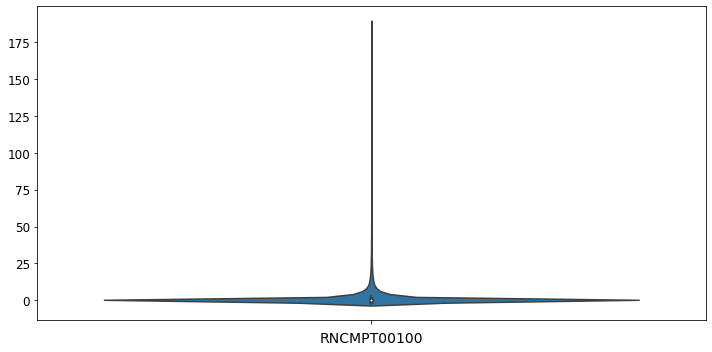

In [33]:
eu.pl.violinplot(
    sdata, 
    keys="RNCMPT00100"
)

# DeepBind Evaluation Metrics

In [233]:
# Useful helpers for generating and checking for kmers

from itertools import product
def generate_all_possible_kmers(n=7, alphabet="AGCU"):
    """
    Generate all possible kmers of length and alphabet provided
    """
    return [''.join(c) for c in product(alphabet, repeat=n)]


def kmer_in_seqs(seqs, kmer):
    """
    Return a 0/1 array of whether a kmer is in each of the passed in sequences
    """
    seqs_s = pd.Series(seqs)
    kmer_binary = seqs_s.str.contains(kmer).astype(int).values
    return kmer_binary


def calc_auc(z, y, want_curve = False):
    # https://github.com/jisraeli/DeepBind/blob/master/code/deepfind.py
   """Given predictions z and 0/1 targets y, computes AUC with optional ROC curve"""
   z = z.ravel()
   y = y.ravel()
   assert len(z) == len(y)

# Remove any pair with NaN in y    
   m = ~np.isnan(y)
   y = y[m]
   z = z[m]
   assert np.all(np.logical_or(y==0, y==1)), "Cannot calculate AUC for non-binary targets"

   order = np.argsort(z,axis=0)[::-1].ravel()   # Sort by decreasing order of prediction strength
   z = z[order]
   y = y[order]
   npos = np.count_nonzero(y)      # Total number of positives.
   nneg = len(y)-npos              # Total number of negatives.
   if nneg == 0 or npos == 0:
       return (np.nan,None) if want_curve else 1

   n = len(y)
   fprate = np.zeros((n+1,1))
   tprate = np.zeros((n+1,1))
   ntpos,nfpos = 0.,0.
   for i,yi in enumerate(y):
       if yi: ntpos += 1
       else:  nfpos += 1
       tprate[i+1] = ntpos/npos
       fprate[i+1] = nfpos/nneg
   auc = float(np.trapz(tprate,fprate,axis=0))
   if want_curve:
       curve = np.hstack([fprate,tprate])
       return auc, curve
   return auc

In [235]:
# Get the hits for k-mers
possible_kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")
k_binary = kmer_in_seqs(seqs=sdata.seqs, kmer=possible_kmers[0])
np.unique(k_binary, return_counts=True)

(array([0, 1]), array([240993,    364]))

In [255]:
from sklearn.metrics import auc
def median_calc(preds, y):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]
    preds = preds[nan_mask]
    indeces_1 = np.where(preds==1)[0]
    return np.median(y[indeces_1])


def auc_calc(preds, y):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]a
    preds = preds[nan_mask]
    order = np.argsort(y)
    y_sorted = y[order]
    preds_sorted = preds[order]
    return auc(y_sorted, preds_sorted)


def escore(preds, y, use_calc_auc=False):
    nan_mask = (~np.isnan(y))
    y = y[nan_mask]
    preds = preds[nan_mask]
    l_0 = np.where(preds == 0)[0]
    l_1 = np.where(preds == 1)[0]
    y_0 = y[l_0]
    y_1 = y[l_1]
    indeces_y_0, indeces_y_1 = np.argsort(y_0)[::-1], np.argsort(y_1)[::-1]
    sorted_y_0, sorted_y_1 = np.sort(y_0)[::-1], np.sort(y_1)[::-1]
    indeces_y_0_top = indeces_y_0[:int(len(sorted_y_0)/2)]
    indeces_y_1_top = indeces_y_1[:int(len(sorted_y_1)/2)]
    sorted_y_0_top = sorted_y_0[:int(len(sorted_y_0)/2)]
    sorted_y_1_top = sorted_y_1[:int(len(sorted_y_1)/2)]
    l_0_top = l_0[indeces_y_0_top]
    l_1_top = l_1[indeces_y_1_top]
    l_top = np.concatenate([l_0_top, l_1_top])
    if use_calc_auc:
        print("HERE")
        return calc_auc(y[l_top], preds[l_top])
    else:
        return auc_calc(preds=preds[l_top], y=y[l_top])

In [253]:
# Real data
preds = k_binary
y = sdata["RNCMPT00100"].values

# Pretend data
#preds = np.array([0, 1, 1, 1, 0, 0, 0, 1])
#y = np.array([0.2, 0.6, 0.8, 0.7, 0.5, 0.3, 0.1, 0.9])

In [256]:
median_calc(preds=preds, y=y), calc_auc(y, preds), auc_calc(preds=preds, y=y), escore(preds=preds, y=y), escore(preds, y, use_calc_auc=True)

HERE


(-0.209522,
 0.3975114205815928,
 0.007971500000000535,
 0.21076850000000052,
 0.21094980526271168)

In [277]:
from tqdm.auto import tqdm
def rna_complete_metrics(probes, intensities, n=7, alphabet="AGCU", num_kmers=None):
    possible_kmers = generate_all_possible_kmers(n=n, alphabet=alphabet)
    num_kmers = len(possible_kmers) if num_kmers is None else num_kmers
    possible_kmers = possible_kmers[:num_kmers]
    kmer_medians, kmer_aucs, kmer_escores = [], [], []
    y = intensities
    for i, kmer in tqdm(enumerate(possible_kmers), desc="Scoring k-mers", total=len(possible_kmers)):
        preds = kmer_in_seqs(seqs=probes, kmer=kmer)
        kmer_medians.append(median_calc(preds=preds, y=y))
        kmer_aucs.append(auc_calc(preds=preds, y=y))
        kmer_escores.append(escores(preds=preds, y=y))
    kmer_medians, kmer_aucs, kmer_escore = np.array(kmer_medians), np.array(kmer_aucs), np.array(kmer_escores)
    kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)
    return kmer_zscores, kmer_aucs, kmer_escores

In [284]:
rna_complete_metrics(probes=sdata.seqs, intensities=sdata["RNCMPT00100"].values, n=7, alphabet="AGCU", num_kmers=100)

Scoring k-mers:   0%|          | 0/100 [00:00<?, ?it/s]

(array([-9.08162948e-01, -5.23714399e-01, -1.17897058e+00, -6.11969054e-01,
        -4.97446474e-01,  4.75726688e-01, -2.58415749e-01, -7.00380132e-01,
        -8.54483777e-01, -4.95498279e-01, -9.37664592e-01, -2.51552983e-01,
        -9.54547053e-01, -3.16537373e-01, -7.80020068e-01, -5.44871512e-01,
        -5.93215188e-01,  4.36088741e-01, -9.63915681e-04, -3.87292401e-01,
         5.09917425e-02,  2.57989671e+00,  7.93595318e-01,  3.06606300e-01,
         1.69740625e-01,  6.24671171e-01, -2.60685325e-01, -8.54483777e-01,
         8.60940294e-01,  9.77342015e-02, -9.45901049e-01, -1.01570047e+00,
        -5.56478204e-01, -7.57500640e-01, -3.66655755e-01, -8.06788551e-01,
        -1.03970814e-01,  7.88362210e-01, -4.40738358e-01, -5.05864951e-01,
        -8.02658947e-01,  4.80907806e-02, -4.66656461e-01, -6.54325941e-01,
        -6.61623851e-01, -2.17034381e-01, -1.00251247e+00, -5.77737704e-01,
        -4.93405036e-01,  2.20260023e-01, -1.25249006e+00, -8.82014474e-01,
        -6.9

---

# Scratch

In [ ]:
# Implementing the escore function

# Pull out one k-mers worth of hits and actuall probe intensities
preds = k_binary
y = sdata["RNCMPT00100"].values

preds = np.array([0, 1, 1, 1, 0, 0, 0, 1])
y = np.array([0.2, 0.6, 0.8, 0.7, 0.5, 0.3, 0.1, 0.9])

# Get the indices where the 7mers are hits and where they are not
l_0 = np.where(preds == 0)[0]
l_1 = np.where(preds == 1)[0]
l_0, l_1

# Get the probe intensities for k-mer hits and not
y_0 = y[l_0]
y_1 = y[l_1]
y_0, y_1

indeces_y_0, indeces_y_1 = np.argsort(y_0)[::-1], np.argsort(y_1)[::-1]
indeces_y_0, indeces_y_1

sorted_y_0, sorted_y_1 = np.sort(y_0)[::-1], np.sort(y_1)[::-1]
sorted_y_0, sorted_y_1

indeces_y_0_top = indeces_y_0[:int(len(sorted_y_0)/2)]
indeces_y_1_top = indeces_y_1[:int(len(sorted_y_1)/2)]
indeces_y_0_top, indeces_y_1_top

sorted_y_0_top = sorted_y_0[:int(len(sorted_y_0)/2)]
sorted_y_1_top = sorted_y_1[:int(len(sorted_y_1)/2)]
sorted_y_0_top, sorted_y_1_top

l_0_top = l_0[indeces_y_0_top]
l_1_top = l_1[indeces_y_1_top]
l_0_top, l_1_top

l_top = np.concatenate([l_0_top, l_1_top])
l_top

preds[l_top], y[l_top]

rna_complete_auc(preds=preds, y=y), rna_complete_auc(preds=preds[l_top], y=y[l_top])

In [271]:
# Implementing the rnacomplete_metrics function
kmer_medians = []
kmer_aucs = []
kmer_escores = []
y = sdata["RNCMPT00100"].values
for i, kmer in tqdm(enumerate(possible_kmers[:n]), desc="Scoring k-mers", total=len(possible_kmers[:n])):
    preds = kmer_in_seqs(seqs=sdata.seqs, kmer=kmer)
    kmer_medians.append(median_calc(preds=preds, y=y))
    kmer_aucs.append(auc_calc(preds=preds, y=y))
    kmer_escores.append(escores(preds=preds, y=y))
kmer_medians = np.array(kmer_medians)
kmer_aucs = np.array(kmer_aucs)
kmer_escore = np.array(kmer_escores)
kmer_zscores = (kmer_medians - np.mean(kmer_medians))/np.std(kmer_medians, ddof=1)

Scoring k-mers:   0%|          | 0/10 [00:00<?, ?it/s]

In [139]:
# Older attempts

from sklearn.metrics import auc
def rna_complete_zscores(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")
    probes_s = pd.Series(probes)
    kmer_indeces = [np.where(probes_s.str.contains(kmer))[0] for kmer in kmers]
    median_kmer_intensities = [np.nanmedian(values[l]) for l in kmer_indeces]
    z_scores = (median_kmer_intensities - np.mean(median_kmer_intensities))/np.std(median_kmer_intensities, ddof=1)
    return z_scores


def rna_complete_zscores(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    probes_s = pd.Series(probes)
    kmer_indeces = [np.where(probes_s.str.contains(kmer))[0] for kmer in kmers[:10]]
    median_kmer_intensities = [np.nanmedian(values[l]) for l in kmer_indeces]
    z_scores = (median_kmer_intensities - np.mean(median_kmer_intensities))/np.std(median_kmer_intensities, ddof=1)
    return z_scores


def rna_complete_aucs(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    kmers_in_probes(probes, kmers):
    order = np.argsort(values)
    true_sorted = values[order]
    preds_sorted = kmer_hits[:, order]
    nan_mask = (~np.isnan(true_sorted))
    true_cleaned = true_sorted[nan_mask]
    preds_cleaned = preds_sorted[:, nan_mask]
    aucs = np.array([auc(true_cleaned, preds) for preds in preds_cleaned])
    return aucs


def rna_complete_aucs(probes, values):
    kmers = generate_all_possible_kmers(n=7, alphabet="AGCU")[:10]
    probes_s = pd.Series(probes)
    kmer_hits = np.array([probes_s.str.contains(kmer).astype(int).values for kmer in kmers[:10]])
    order = np.argsort(values)
    true_sorted = values[order]
    preds_sorted = kmer_hits[:, order]
    nan_mask = (~np.isnan(true_sorted))
    true_cleaned = true_sorted[nan_mask]
    preds_cleaned = preds_sorted[:, nan_mask]
    aucs = np.array([auc(true_cleaned, preds) for preds in preds_cleaned])
    return aucs


def rna_complete_aucs(kmer_binary, values):
    """
    Returns RNAcomplete/DeepBind style AUCs for multiple k-mers at once
    
    Params
    ------
    kmer_binary
        a 
    
    """
    nan_mask = (~np.isnan(values))
    true = values[nan_mask]
    preds = kmer_binary[:, nan_mask]
    order = np.argsort(true)
    true_sorted = true[order]
    preds_sorted = preds[:, order]
    aucs = np.array([auc(true_sorted, preds) for preds in preds_sorted])
    return aucs

rna_complete_zscores(probes=sdata.seqs, values=sdata["RNCMPT00100"])
rna_complete_aucs(k_binary, sdata["RNCMPT00100"].values)
rna_complete_aucs(probes=sdata.seqs, values=sdata["RNCMPT00100"].values)